In [33]:
tf.reset_default_graph()

In [34]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Simple, end-to-end, LeNet-5-like convolutional MNIST model example.

This should achieve a test error of 0.7%. Please keep this model as simple and
linear as possible, it is meant as a tutorial for simple convolutional models.
Run with --self_test on the command line to execute a short self-test.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import gzip
import os
import sys
import time

import numpy 
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# CVDF mirror of http://yann.lecun.com/exdb/mnist/
SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 10
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.


def data_type():
  """Return the type of the activations, weights, and placeholder variables."""
  return tf.float32


def maybe_download(filename):
  """Download the data from Yann's website, unless it's already here."""
  if not tf.gfile.Exists(WORK_DIRECTORY):
    tf.gfile.MakeDirs(WORK_DIRECTORY)
  filepath = os.path.join(WORK_DIRECTORY, filename)
  if not tf.gfile.Exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
      size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
  return filepath


def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].

  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
    data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data


def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
  return labels

def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])

# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 6000)
train_labels = extract_labels(train_labels_filename, 6000)
test_data = extract_data(test_data_filename, 1000)
test_labels = extract_labels(test_labels_filename, 1000)

# Generate a validation set.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]
num_epochs = NUM_EPOCHS
train_size = train_labels.shape[0]

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
train_data_node = tf.placeholder(
    data_type(),
    shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
eval_data = tf.placeholder(
    data_type(),
    shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when we call:
# {tf.global_variables_initializer().run()}
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED, dtype=data_type()))
conv1_biases = tf.Variable(tf.zeros([32], dtype=data_type()))
conv2_weights = tf.Variable(tf.truncated_normal(
  [5, 5, 32, 64], stddev=0.1,
  seed=SEED, dtype=data_type()))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=data_type()))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED,
                      dtype=data_type()))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=data_type()))
fc2_weights = tf.Variable(tf.truncated_normal([512, NUM_LABELS],
                                            stddev=0.1,
                                            seed=SEED,
                                            dtype=data_type()))
fc2_biases = tf.Variable(tf.constant(
  0.1, shape=[NUM_LABELS], dtype=data_type()))

# We will replicate the model structure for the training subgraph, as well
# as the evaluation subgraphs, while sharing the trainable parameters.
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    # Max pooling. The kernel size spec {ksize} also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
      hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
              tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=data_type())
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                     0.9).minimize(loss,
                                                   global_step=batch)

# Predictions for the current training minibatch.
train_prediction = tf.nn.softmax(logits)

# Predictions for the test and validation, which we'll compute less often.
eval_prediction = tf.nn.softmax(model(eval_data))

###############################################################################
############################## BEGIN ADDED CODE ###############################

# Extension of the MNIST model to support single image input/output.
single_image = tf.placeholder(data_type(),
                              shape=(1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
single_prediction = tf.nn.softmax(model(single_image))

# Parameters and variables for generating adversarial images.
x = tf.placeholder(tf.float32, (1,28,28,1), name='x')        # Input
c = tf.placeholder(tf.float32, (), name='c')                 # Hyperparameter
target = tf.placeholder(tf.int32, (), name='target')         # Target class
delta = tf.get_variable('delta',[1,28,28,1],tf.float32, 
                        initializer = tf.initializers.zeros) # Distortion   

# Box constraint to ensure all pixels are within the range (-0.5, 0.5)
x_scaled = x + 0.5                                      # Rescale to (0,1) 
w = tf.atanh(x_scaled)                                  # w_i = arctanh(x_i)
adv_image = tf.tanh(w + delta) - 0.5                    # Transform and rescale
adv_logits = model(adv_image)                           # Logits from model

# Loss Function as formulated on page 9 of Carlini & Wagner.
# minimize ||x'-x||_2^2 + c * f(x'), where
# f(x') = max(max{Z(x')_i : i!= t} - Z(x')_t, -k)
distance_loss = tf.reduce_mean(tf.square(adv_image - x)) # ||x'-x||_2^2
inner = tf.reduce_max(adv_logits)                        # max{Z(x')_i : i!= t}
outer = tf.reduce_max(adv_logits -                       # Z(x')_t
                   tf.one_hot(
                       tf.fill([1],target),
                       10,
                       on_value=0.0,
                       off_value=float('inf')))
misclassify_loss = tf.nn.relu(inner - outer)       # f(x')
adv_loss = distance_loss + c * misclassify_loss          # Final loss function

# Optimizer
adv_optimizer = tf.train.AdamOptimizer(learning_rate = 1e-2)
adv_train_op = adv_optimizer.minimize(adv_loss, var_list=[delta])

image = [test_data[1]] # size = (1, 28, 28, 1)

############################## END ADDED CODE #################################
###############################################################################

# Small utility function to evaluate a dataset by feeding batches of data to
# {eval_data} and pulling the results from {eval_predictions}.
# Saves memory and enables this to run on smaller GPUs.
def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
      raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = numpy.ndarray(shape=(size, NUM_LABELS), dtype=numpy.float32)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
      end = begin + EVAL_BATCH_SIZE
      if end <= size:
        predictions[begin:end, :] = sess.run(
            eval_prediction,
            feed_dict={eval_data: data[begin:end, ...]})
      else:
        batch_predictions = sess.run(
            eval_prediction,
            feed_dict={eval_data: data[-EVAL_BATCH_SIZE:, ...]})
        predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

# Create a local session to run the training.
export_dir = '/tmp/final_model'
saver = tf.train.Saver()
start_time = time.time()
with tf.Session() as sess:
    # Run all the initializers to prepare the trainable parameters.
    tf.global_variables_initializer().run()
    print('Initialized!')
    # Loop through training steps.
    for step in xrange(int(num_epochs * train_size) // BATCH_SIZE):
      # Compute the offset of the current minibatch in the data.
      # Note that we could use better randomization across epochs.
      offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
      batch_data = train_data[offset:(offset + BATCH_SIZE), ...]
      batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
      # This dictionary maps the batch data (as a numpy array) to the
      # node in the graph it should be fed to.
      feed_dict = {train_data_node: batch_data,
                   train_labels_node: batch_labels}
      # Run the optimizer to update weights.
      sess.run(optimizer, feed_dict=feed_dict)
      # print some extra information once reach the evaluation frequency
      if step % EVAL_FREQUENCY == 0:
        # fetch some extra nodes' data
        l, lr, predictions = sess.run([loss, learning_rate, train_prediction],
                                      feed_dict=feed_dict)
        elapsed_time = time.time() - start_time
        start_time = time.time()
        print('Step %d (epoch %.2f), %.1f ms' %
              (step, float(step) * BATCH_SIZE / train_size,
               1000 * elapsed_time / EVAL_FREQUENCY))
        print('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
        print('Minibatch error: %.1f%%' % error_rate(predictions, batch_labels))
        print('Validation error: %.1f%%' % error_rate(
            eval_in_batches(validation_data, sess), validation_labels))
        sys.stdout.flush()
    # Finally print the result!
    test_error = error_rate(eval_in_batches(test_data, sess), test_labels)
    print('Test error: %.1f%%' % test_error)
    saver.save(sess, export_dir)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Initialized!
Step 0 (epoch 0.00), 2.4 ms
Minibatch loss: 8.334, learning rate: 0.010000
Minibatch error: 85.9%
Validation error: 84.6%
Step 100 (epoch 6.40), 78.0 ms
Minibatch loss: 3.228, learning rate: 0.007351
Minibatch error: 3.1%
Validation error: 8.6%
Test error: 7.8%


In [35]:
# Find indices of images that are labeled 2
def find_twos_indices(test_labels):
    indices = []
    for i in range(len(test_labels)):
        if test_labels[i] == 2:
            indices.append(i)
        if len(indices) == 10:
            break
    return indices
indices = find_twos_indices(test_labels)

In [36]:
def plot(orig_images, orig_probs, adv_images, adv_probs):
    %matplotlib inline    
    fig = plt.figure(figsize=(5, 12))
    gs = gridspec.GridSpec(11,3,wspace=0.1,hspace=0.1)
    for i in range(10):
        # Original Image
        ax = fig.add_subplot(gs[i,0])
        ax.imshow(numpy.squeeze(orig_images[i]), cmap='gray')
        ax.set_xlabel('2 ({0:.1%})'.format(orig_probs[i]), fontsize=12)
        if i == 0:
            ax.set_title('Original',fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Delta
        ax = fig.add_subplot(gs[i,1])
        img = ax.imshow(numpy.squeeze(adv_images[i]-orig_images[i]), cmap='gray')
        if i == 0:
            ax.set_title('Delta',fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Adversarial Image
        ax = fig.add_subplot(gs[i,2])
        img = ax.imshow(numpy.squeeze(adv_images[i]), cmap='gray')
        if i == 0:
            ax.set_title('Adversarial',fontsize=18)
        ax.set_xlabel('6 ({0:.1%})'.format(adv_probs[i]), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        
    gs.tight_layout(fig)
    os.makedirs('img', exist_ok=True)
    plt.savefig('img/adversarial_attack.png')
    plt.show()

INFO:tensorflow:Restoring parameters from /tmp/final_model


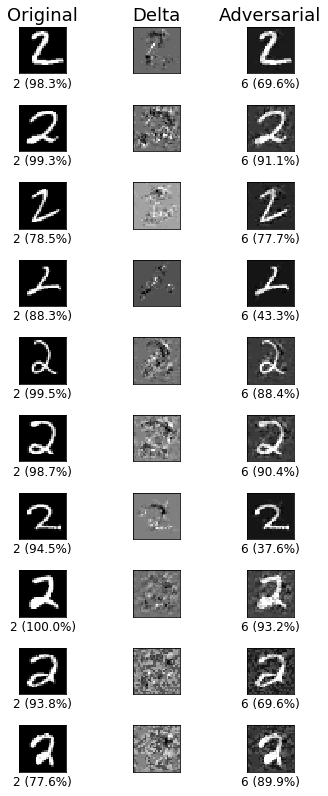

In [37]:
with tf.Session() as sess:
    saver.restore(sess, export_dir)
    twos = test_data[indices]
    orig_images = []
    orig_probs = []
    adv_images = []
    adv_probs = []
    
    for image in twos:
        image = [image]
        feed_dict = {
            x: image,
            c: 0.4,
            target: 6
        }
        
        # Initialize delta before every iteration in binary search
        #sess.run(tf.variables_initializer([delta]))


        # train model to find best xadv according to loss 
        for i in range(10000):
            sess.run(adv_train_op, feed_dict = feed_dict)
        
        orig_image = image
        orig_images.append(orig_image)
        orig_prob = numpy.max(sess.run(single_prediction,
                                       feed_dict = {single_image: orig_image}))
        orig_probs.append(orig_prob)
        
        # get adversarial image
        adv_image1 = sess.run(adv_image, feed_dict=feed_dict)
        adv_images.append(adv_image1)

        # use model to predict label and probability
        adv_prob1 = numpy.max(sess.run(single_prediction,
                                      feed_dict = {single_image: adv_image1}))
        adv_probs.append(adv_prob1)
    
    plot(orig_images, orig_probs, adv_images, adv_probs)
